In [1]:
import pickle
import sys
from tqdm import tqdm
import numpy as np
sys.path.append('..')
import eval
import numpy as np
import random

In [2]:
dataset='feature_norms'
noun2prop = pickle.load(open('../data/datasets/{}/noun2property/noun2prop{}.p'.format(dataset, '_test' if dataset == 'concept_properties' else ''), "rb"))
gpt3_predicts = pickle.load(open(f'../output/output_{dataset}/gpt3_predicts.p', "rb"))
roberta_predicts = pickle.load(open(f'../output/output_{dataset}/roberta-large+singular_generally.p', "rb"))
bert_predicts = pickle.load(open(f'../output/output_{dataset}/bert-large-uncased+plural_most.p', "rb"))
gpt_predicts = pickle.load(open(f'../output/output_{dataset}/gpt2-large+plural_most.p', "rb"))
vilt_predicts = pickle.load(open(f'../output/output_{dataset}/vilt+plural+10.p', "rb"))
clip_predicts = pickle.load(open(f'../output/output_{dataset}/clip_scores.p', "rb"))
combined_predicts = pickle.load(open(f'../output/output_{dataset}/combine_scores.p', "rb"))
pred_combined_predicts = pickle.load(open(f'../output/output_{dataset}/pred_combined_scores.p', "rb"))

model2predicts = {"BERT": bert_predicts, "RoBERTa": roberta_predicts, "GPT2": gpt_predicts, "GPT3": gpt3_predicts, "ViLT": vilt_predicts, "CLIP": clip_predicts, "CEM-Gold": combined_predicts, 'CEM-Pred': pred_combined_predicts}

In [71]:
def get_model2pred2nouns(k):
    model2pred2nouns = {}
    for model, noun2predicts in model2predicts.items():
        pred2nouns = {}
        for noun, pred in noun2predicts.items():
            if tuple(pred[:k]) in pred2nouns:
                pred2nouns[tuple(pred[:k])].append(noun)
            else: 
                pred2nouns[tuple(pred[:k])]= [noun]
        
        model2pred2nouns[model] = pred2nouns
    return model2pred2nouns

dups = []
for k in [3,4,5]:
    dups.append(get_model2pred2nouns(k))

In [79]:
model2dupnouns = {}
for model in model2predicts.keys():
    model2dupnouns[model] = []
    for i in range(0):
          model2dupnouns[model].append(sum([len(v) for k,v in dups[i][model].items() if len(v) > 1]))

In [76]:
import numpy as np
import matplotlib.pyplot as plt
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=False):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = ['grey', 'teal', 'orange', 'gold', 'blue', 'green', 'pink', 'brown']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(3+x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
            off = .03 if y%100 != y else 0.02
            off = .01 if y%10 == y else off
            ax.text(3+x + x_offset-off, y+0.14,str(np.round(y, 2)))# width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(),ncol=len(data.keys())//2)

In [77]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
csfont = {'fontname':'Times New Roman'}
plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"

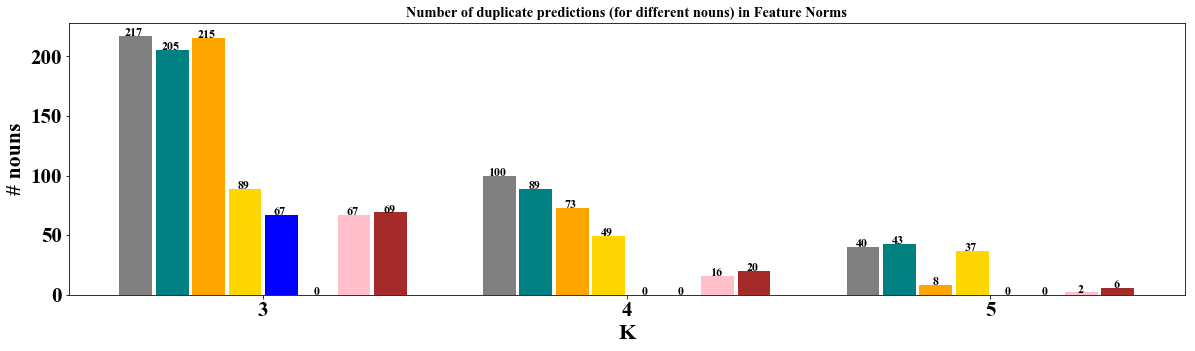

In [78]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
bar_plot(ax, model2dupnouns, total_width=.8, single_width=.9)
ax.tick_params(axis='both', which='major', labelsize=21)
plt.xticks([3, 4, 5])
plt.xlabel("K",fontsize=22)
plt.ylabel('# nouns',fontsize=22)
plt.title("Number of duplicate predictions (for different nouns) in {}".format("Concept Properties-test" if dataset == 'concept_properties' else "Feature Norms"))
plt.savefig(f'duplicates_{dataset}_one_col.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()